Step 7 - Prepering data and plotting dendrograms

In this step the growth data are prepared in a form of a matrix for each timepoint. The matrices are than used to plot clustered heatmaps (dendrograms), which show groups of TFs and conditions by their relation.

In [3]:
from datetime import datetime
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
# Import the data

IMPORT_PATH = os.path.join(os.getcwd(), "output_data")

# Use the latest excel file as an input (default option)
available_results = glob.glob(os.path.join(IMPORT_PATH, '*growth_data.xlsx'))
latest_file = max(available_results)
data = pd.read_excel(latest_file)

'''
Or enter the exact filename generated in the 01_data_import.ipynb script as an input

data = pd.read_excel('XXX_growth_data.xlsx')
'''

print(latest_file)

z:\home\marysia\stress_resistance_msc\output_data\2025-10-27_growth_data.xlsx


In [5]:
data = data.drop(['ECY_number', 'absorbance_600', 'TF', 'modification', 'variant_column'], axis=1)

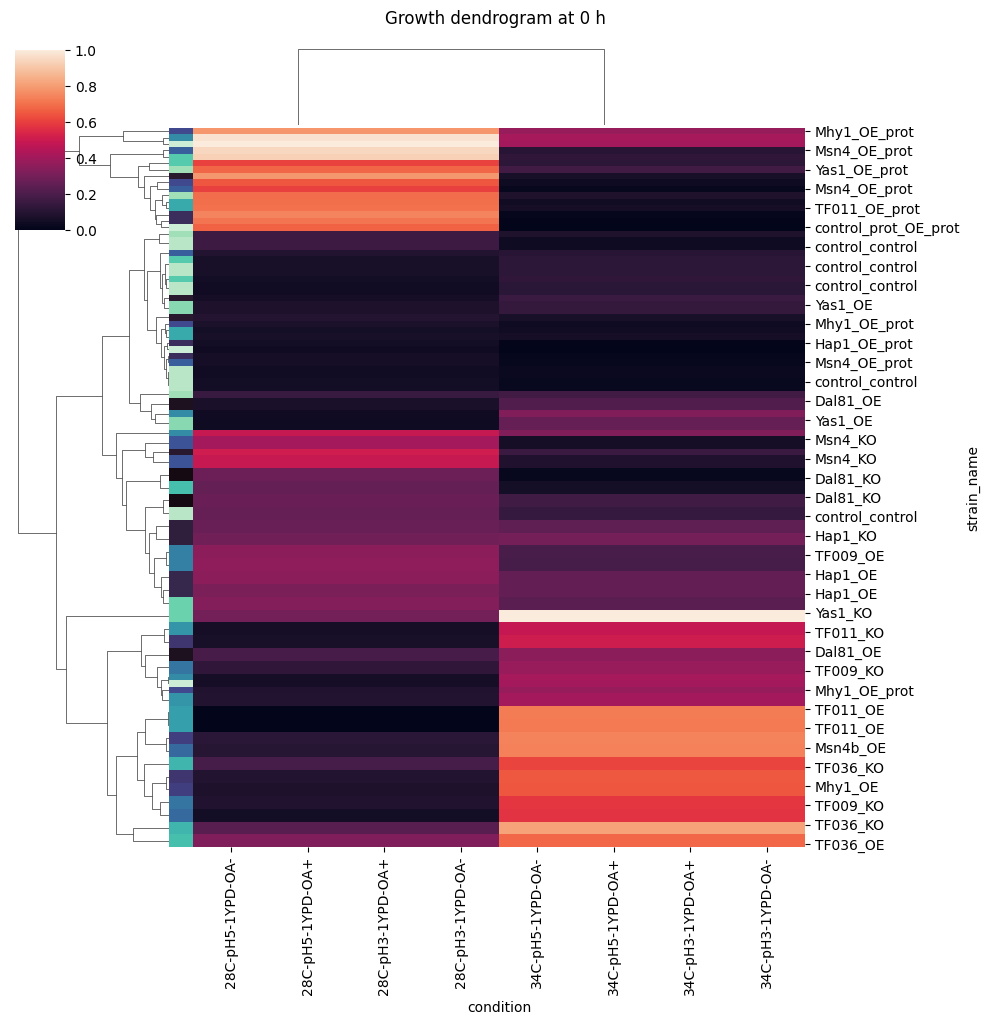

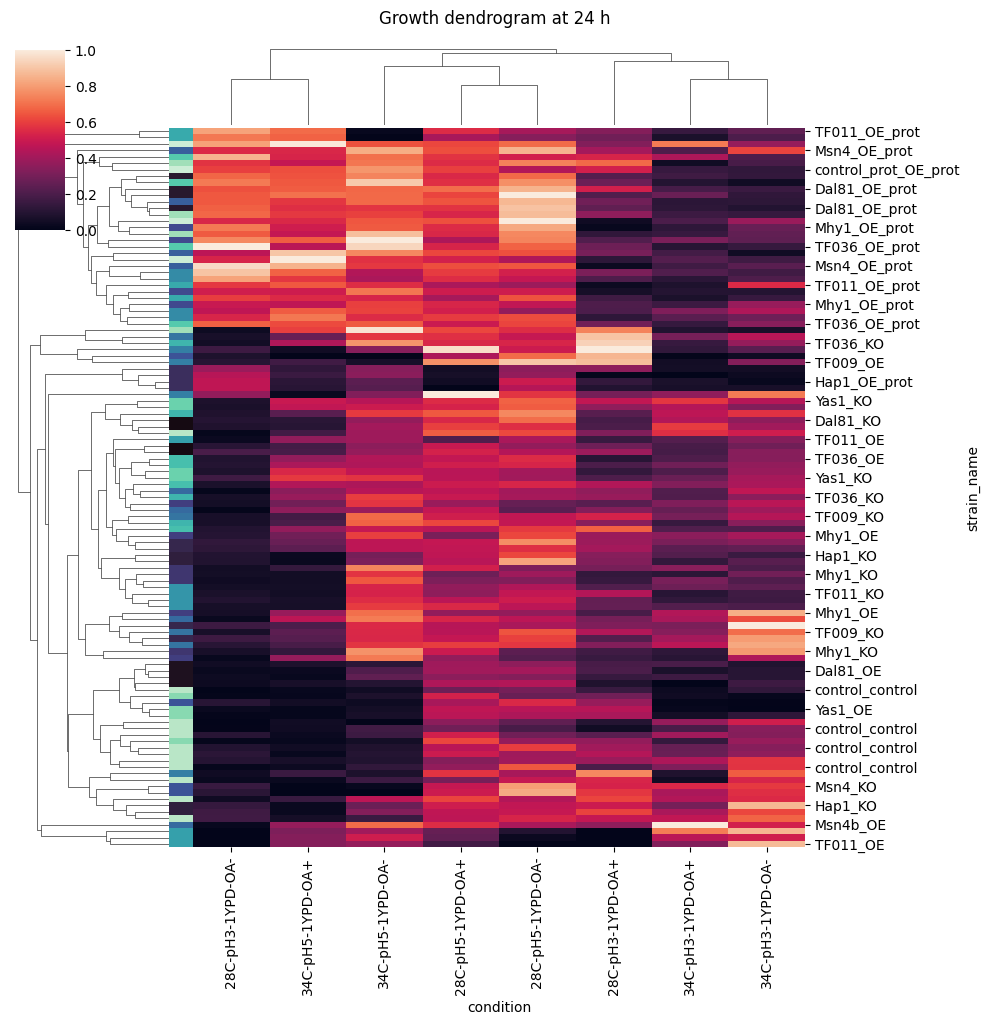

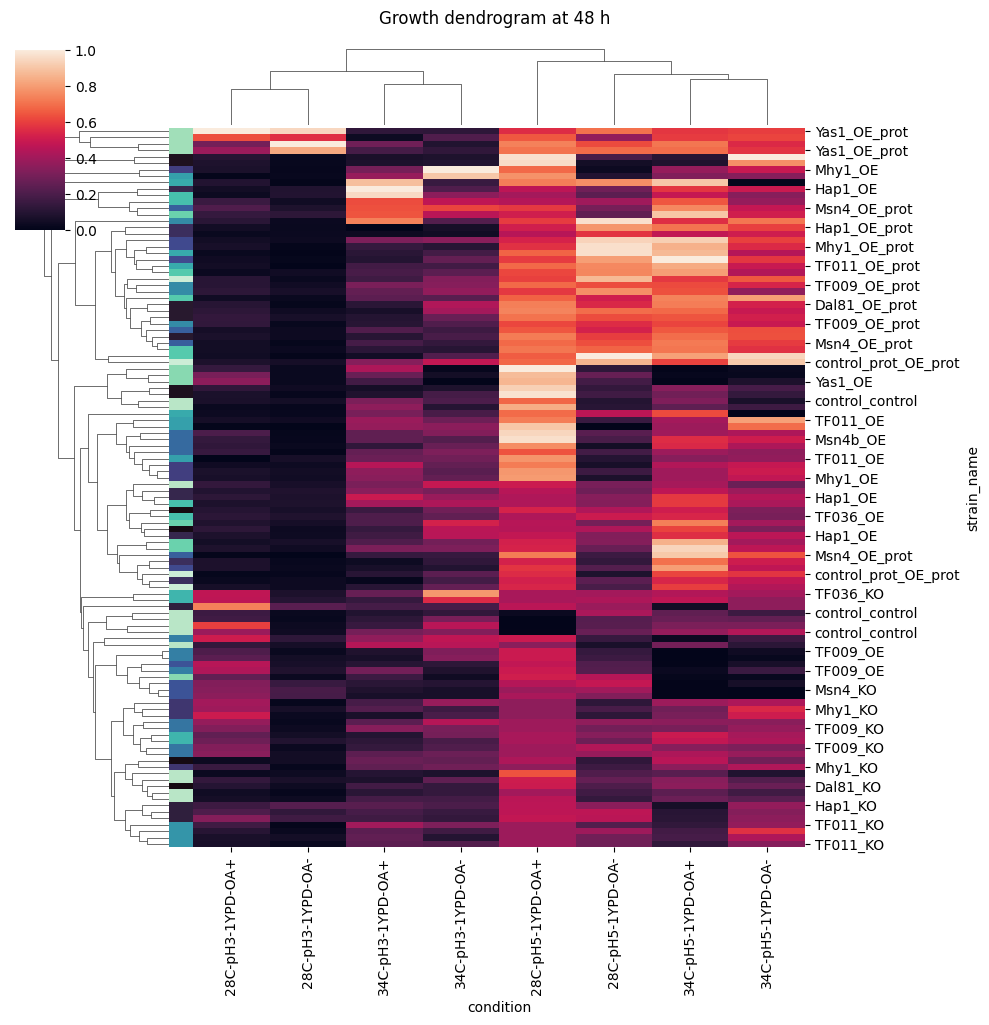

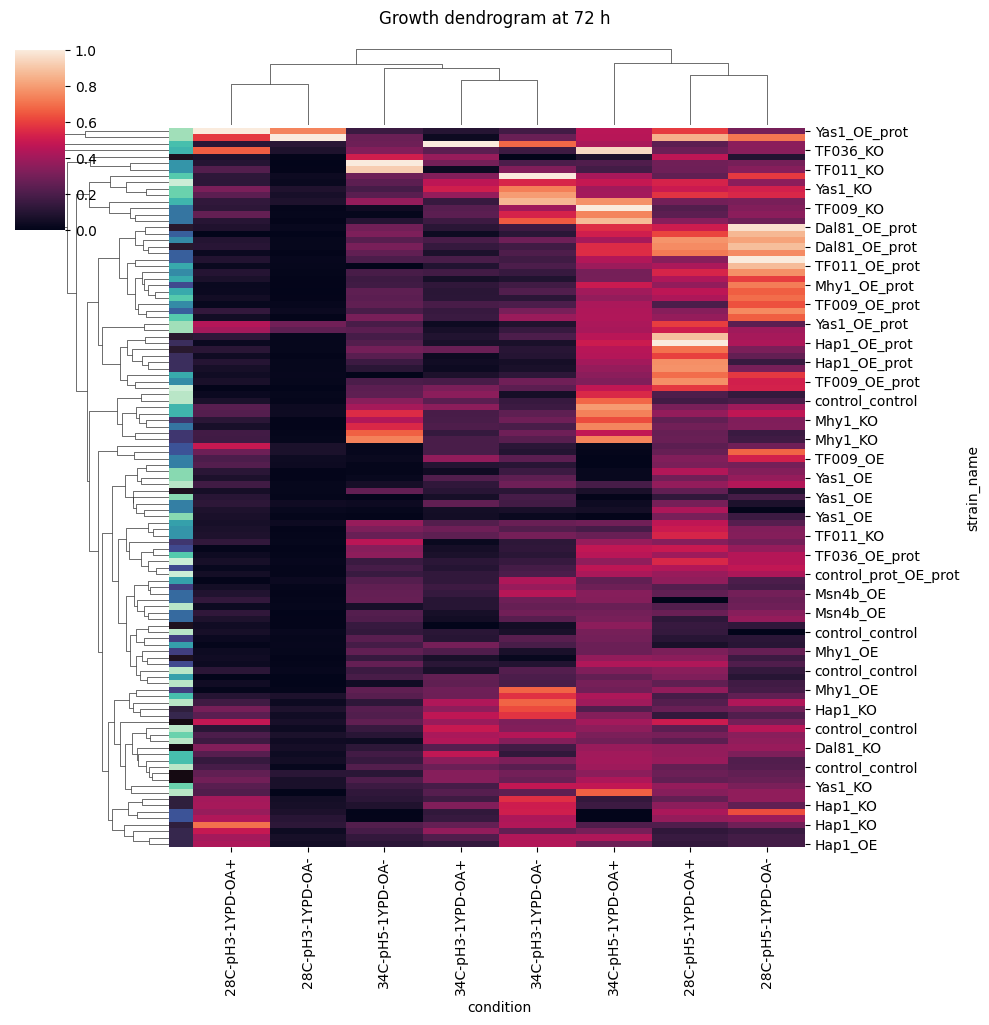

In [6]:
timepoints = data['time'].unique()

for time in timepoints:
    df_time = data.loc[data['time'] == time, ['strain_name','condition','growth']].copy()

    # Give each duplicate (condition, strain_name) a replicate number (1,2,3,...)
    df_time['rep'] = df_time.groupby(['condition','strain_name']).cumcount() + 1

# Build the matrix: rows = (strain, rep), cols = conditions, values = growth
    matrix = (df_time
           .pivot(index=['strain_name','rep'], columns='condition', values='growth')
           .reset_index())
    matrix = matrix.drop(columns=['rep'], axis=1).set_index('strain_name')

    strains = matrix.index.unique()
    colors = sns.color_palette("mako", len(strains))
    labels = dict(zip(strains, colors))
    row_colors = matrix.index.map(labels)
        
  # Plot
    g = sns.clustermap(matrix, 
                       row_colors=row_colors, 
                       standard_scale=1,
                       dendrogram_ratio=(0.2, 0.1))               
    g.figure.suptitle(f"Growth dendrogram at {time} h", y=1.02)
    plt.show()

In [29]:
VISUALISATION_PATH = os.path.join(os.getcwd(), "visualisations")

current_date = datetime.now().strftime("%Y-%m-%d")

In [7]:
data['mean_growth'] = data.groupby(['time', 'condition', 'strain_name'])['growth'].transform('mean')

data_mean = data.drop('growth', axis=1).drop_duplicates()


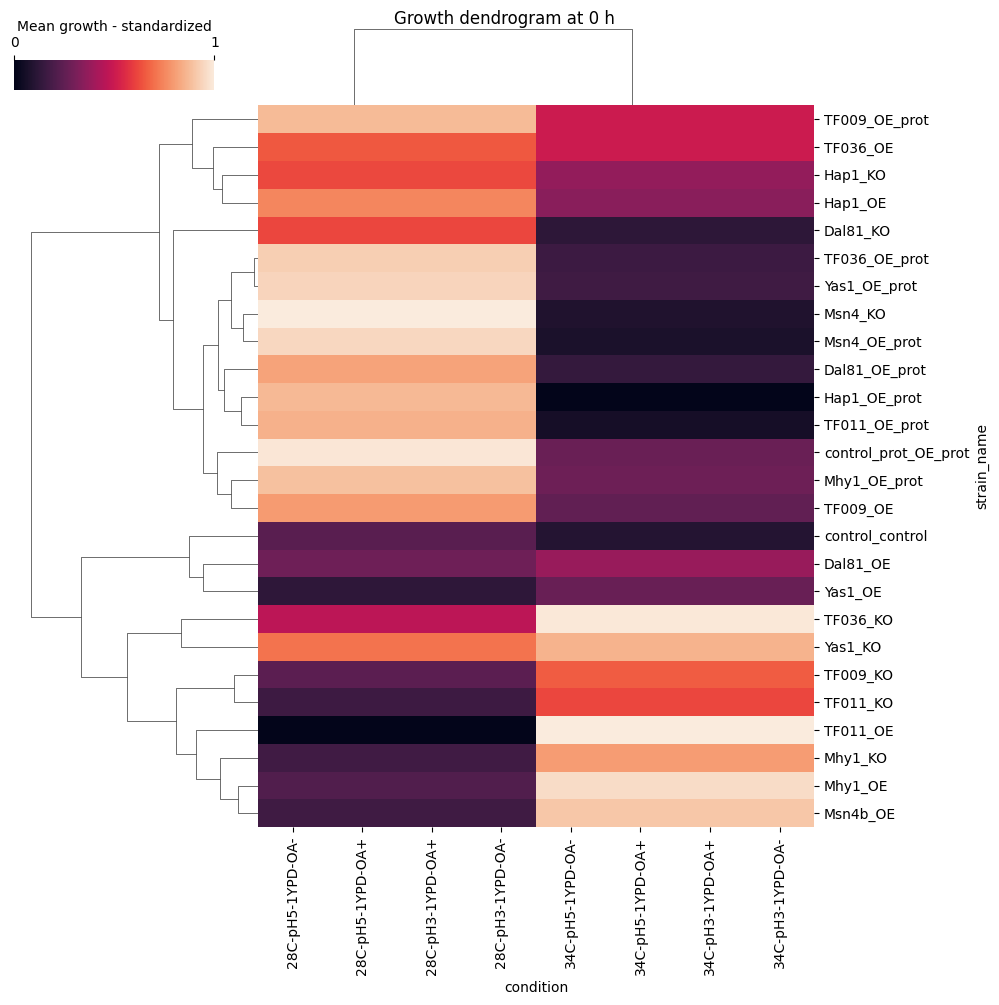

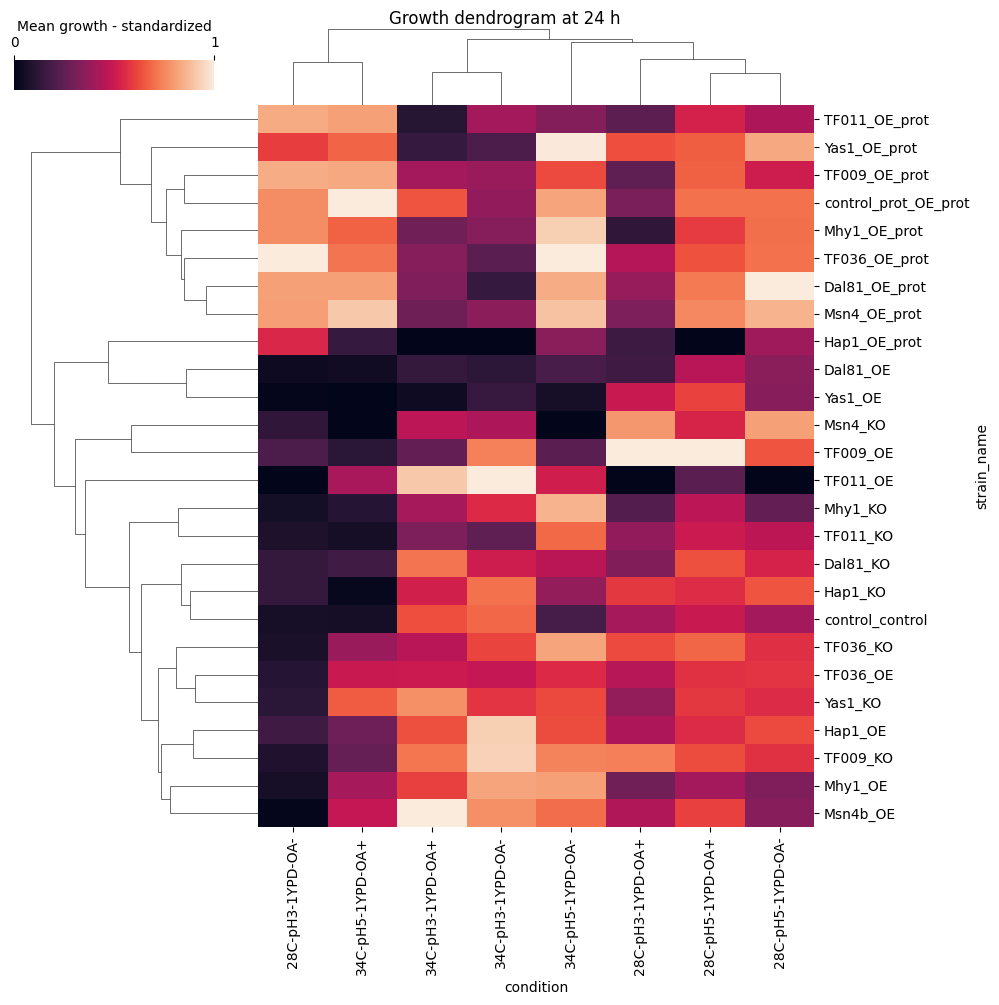

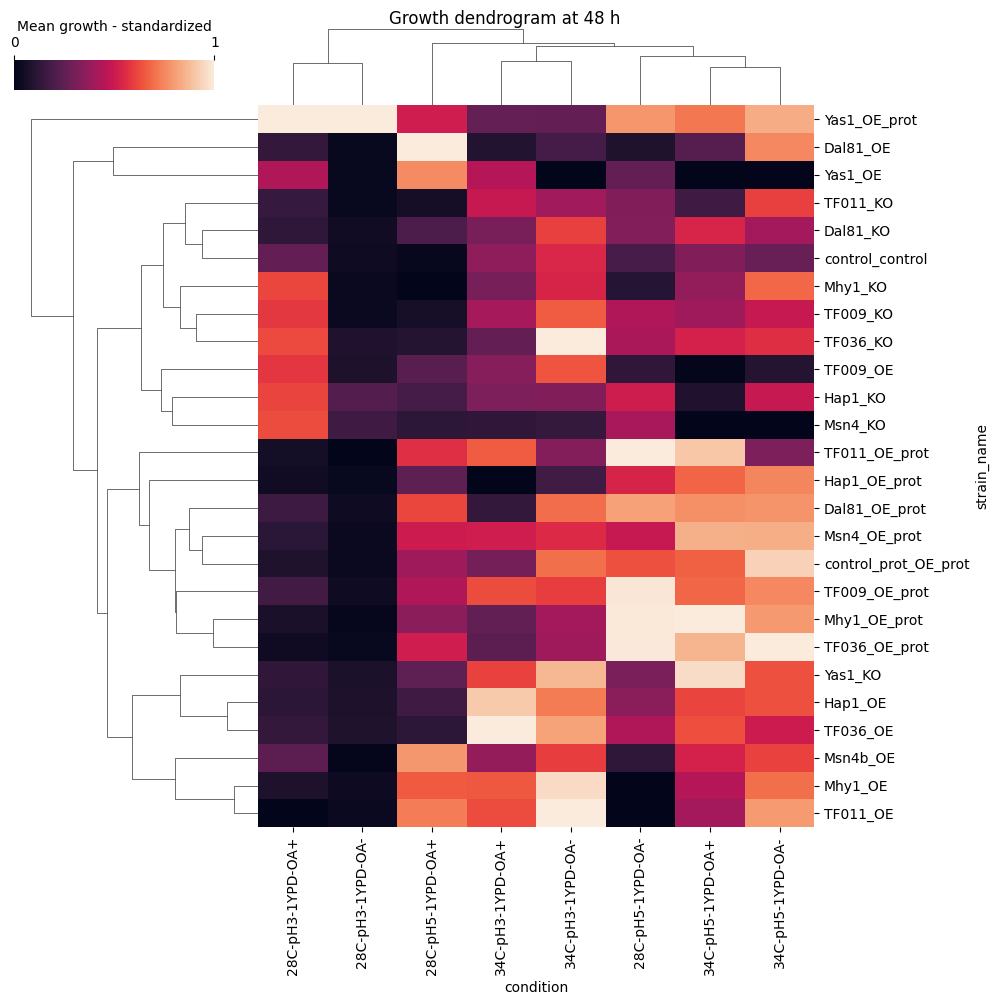

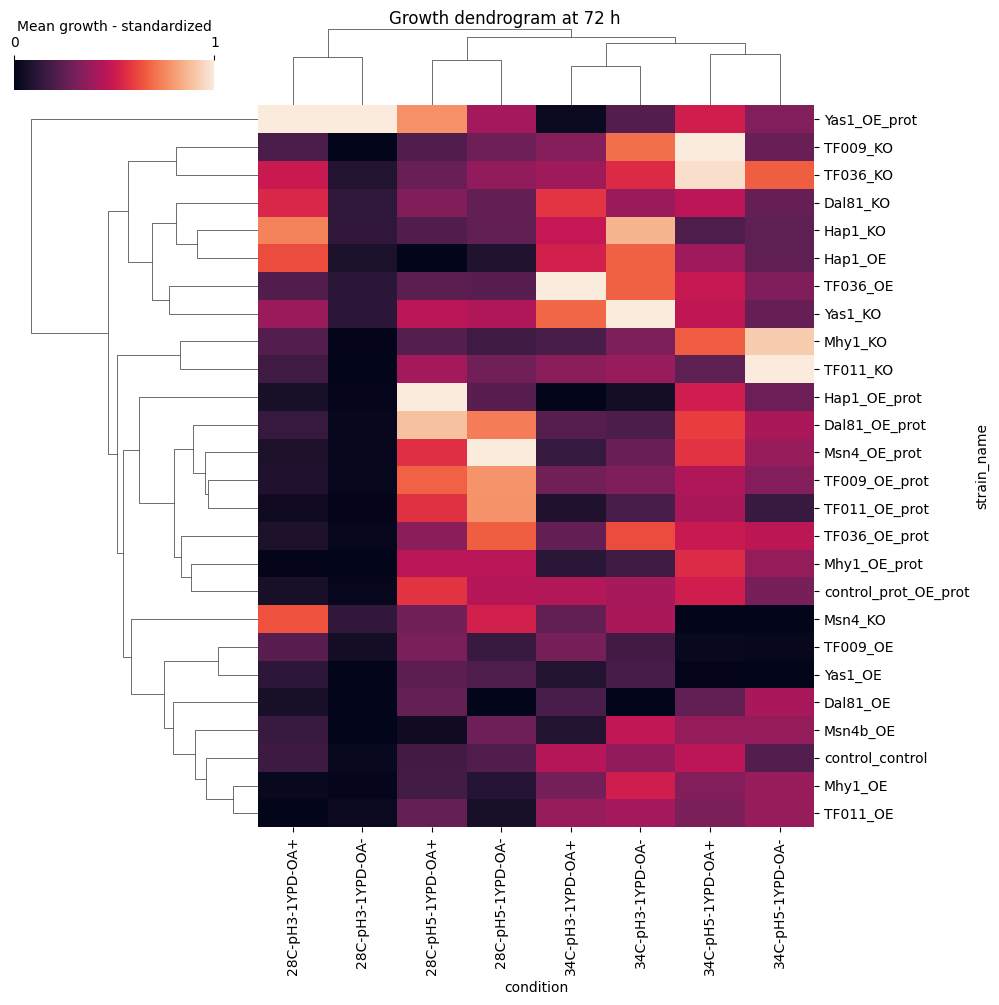

In [47]:
timepoints = data_mean['time'].unique()
current_date = datetime.now().strftime("%Y-%m-%d")

for time in timepoints:
    data_time = data_mean[data_mean['time'] == time]
    data_pivot = data_time.pivot(index='strain_name', columns='condition', values='mean_growth')
    fig = sns.clustermap(data_pivot, 
                         standard_scale=1,
                         dendrogram_ratio=(0.3, 0.1),
                         figsize=(10, 10),
                         cbar_pos=(0.01, 0.92, 0.2, 0.03),
                         cbar_kws={
                             'orientation': 'horizontal',
                             'location': 'top',
                             'label': 'Mean growth - standardized',
                             'ticks': [0,1],
                             'format':'%0.0f'
                            }
                         )
    fig.figure.suptitle(f"Growth dendrogram at {time} h", y=1)

    output_filename = f"{current_date}_dendrogram_time_{time}.png"
    output_path = os.path.join(VISUALISATION_PATH, output_filename)
    fig.figure.savefig(output_path, dpi=600)